# Análise de dados do Ar

## Fonte dos dados
[Air Quality Open Data Platform](https://aqicn.org/data-platform/covid19/)

The data for each major cities is based on the average (median) of several stations. The data set provides min, max, median and standard deviation for each of the air pollutant species (PM2.5,PM10, Ozone ...) as well as meteorological data (Wind, Temperature, ...). All air pollutant species are converted to the US EPA standard (i.e. no raw concentrations). All dates are UTC based. The count column is the number of samples used for calculating the median and standard deviation.

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import json
pd.set_option('display.max_columns', None)

# use glob to get all the csv files
# in the folder
path = os.path.abspath('../data/air-quality')
csv_files = glob.glob(os.path.join(path, "*.csv"))

# loop over the list of csv files
df_raw = pd.DataFrame()
for f in csv_files:
    df_tmp = pd.read_csv(f,comment='#')
    df_raw = pd.concat([df_raw, df_tmp])

In [2]:
df_raw.columns = df_raw.columns.str.upper()

Buscando informações sobre as cidades

In [3]:
cities_data = []
with open('../data/air-quality/airquality-covid19-cities.json', encoding="utf-8") as json_file:
    cities_data = json.load(json_file)['data']

In [4]:
print(len(df_raw), "Rows")
print(len(cities_data), "Cities")

10124378 Rows
618 Cities


In [5]:
df_raw.head(3)

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE
0,2020-04-15,IN,Thrissur,wind-gust,3,10.2,10.2,10.2,0.0
1,2020-04-26,IN,Thrissur,wind-gust,3,12.8,12.8,12.8,0.0
2,2020-05-02,IN,Thrissur,wind-gust,3,8.7,8.7,8.7,0.0


In [6]:
df_raw.describe(include="all")

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE
count,10124378,10124378,10124378,10124378,1.012438e+07,1.012438e+07,1.012438e+07,1.012438e+07,1.012438e+07
unique,2106,95,616,24,NaN,NaN,NaN,NaN,NaN
top,2020-01-05,CN,London,pm25,NaN,NaN,NaN,NaN,NaN
freq,14200,1049342,36307,992557,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.277638e+02,8.998309e+01,1.235257e+02,1.029449e+02,6.404836e+03
std,NaN,NaN,NaN,NaN,1.809249e+02,2.715001e+02,2.750709e+02,2.704365e+02,2.063434e+05
min,NaN,NaN,NaN,NaN,2.000000e+00,-3.276600e+03,-3.065600e+03,-3.065600e+03,0.000000e+00
25%,NaN,NaN,NaN,NaN,4.400000e+01,1.000000e+00,1.060000e+01,4.200000e+00,2.225000e+01
50%,NaN,NaN,NaN,NaN,7.200000e+01,4.500000e+00,2.850000e+01,1.400000e+01,1.429300e+02
75%,NaN,NaN,NaN,NaN,1.440000e+02,2.000000e+01,7.890000e+01,3.960000e+01,8.826700e+02


In [7]:
df_raw.dtypes

DATE         object
COUNTRY      object
CITY         object
SPECIE       object
COUNT         int64
MIN         float64
MAX         float64
MEDIAN      float64
VARIANCE    float64
dtype: object

## Convertendo data e filtrando

In [8]:
df_raw['DATE'] = pd.to_datetime(df_raw['DATE'], format='%Y-%m-%d')

### Tipos de gases/fênomenos no ar

In [9]:
species_list = df_raw['SPECIE'].unique()
print(species_list)

['wind-gust' 'wind speed' 'o3' 'pm25' 'no2' 'pressure' 'wind-speed' 'dew'
 'co' 'temperature' 'pm10' 'humidity' 'so2' 'wind gust' 'wd'
 'precipitation' 'pm1' 'uvi' 'aqi' 'mepaqi' 'neph' 'pol' 'd' 'psi']


***Desejados***
 - Monóxido de Carbono -> Queima incompleta de combustíveis derivados de petróleo, ou seja, substâncias ricas em carbono.
 - Partículas com diâmetro inferior a 25 micrómetros
 - Partículas com diâmetro inferior a 10 micrómetros
 - ~~Partículas com diâmetro inferior a 1 micrómetros~~ Retirado pois tinha cobertura baixa
 - Ozônio -> Aquecimento global
 - Dióxido de enxofre -> Chuvas Ácidas
 - Dióxido de nitrogénio -> Chuvas Ácidas

In [10]:
species_list = ['co', 'pm25', 'pm10', 'o3', 'so2', 'no2']

Filtrando só os gases que importam para a análise

In [11]:
df = df_raw[df_raw[['SPECIE']].isin(species_list).any(axis=1)]

In [12]:
print(len(df), "Rows")

5450107 Rows


### Removendo nulos

In [13]:
df[df['MEDIAN'].isna()]

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE


In [14]:
df[df['MEDIAN'].isnull()]

,DATE,COUNTRY,CITY,SPECIE,COUNT,MIN,MAX,MEDIAN,VARIANCE


In [15]:
df = df.drop(df[df.MEDIAN == 999.0].index)

In [16]:
df_by_year_specie = df.groupby([df.DATE.dt.year, df.COUNTRY, df.SPECIE])['MEDIAN'].mean().rename('MEAN_BY_COUNTRY').reset_index()
df_by_year_specie

,DATE,COUNTRY,SPECIE,MEAN_BY_COUNTRY
0,2014,AT,co,0.100000
1,2014,AT,no2,17.886667
2,2014,AT,pm10,24.200000
3,2014,AT,pm25,83.000000
4,2014,AT,so2,2.100000
...,...,...,...,...
3173,2022,ZA,no2,5.744677
3174,2022,ZA,o3,6.441432
3175,2022,ZA,pm10,31.297930
3176,2022,ZA,pm25,57.365116


In [17]:
df_co = df_by_year_specie.query(f'SPECIE == "co"')
df_pm25 = df_by_year_specie.query(f'SPECIE == "pm25"')
df_pm10 = df_by_year_specie.query(f'SPECIE == "pm10"')
df_o3 = df_by_year_specie.query(f'SPECIE == "o3"')
df_so2 = df_by_year_specie.query(f'SPECIE == "so2"')
df_no2 = df_by_year_specie.query(f'SPECIE == "no2"')

In [18]:
dfs = [df_co,
df_pm25,
df_pm10,
df_o3,
df_so2,
df_no2]

In [19]:
dfs_pivot = []
for df_specie in dfs:
    df_specie = df_specie.pivot(index='DATE', columns='COUNTRY', values='MEAN_BY_COUNTRY')
    dfs_pivot.append(df_specie)

In [20]:
df_co.head(2)

,DATE,COUNTRY,SPECIE,MEAN_BY_COUNTRY
0,2014,AT,co,0.10000
5,2014,AU,co,3.12381


In [21]:
dfs_pivot[0]

COUNTRY,AE,AR,AT,AU,BA,BE,BG,BR,CA,CL,CN,CO,CY,DE,DK,EC,ES,FI,FR,GB,GE,GR,GT,HK,HR,HU,IL,IN,IR,IS,IT,JO,JP,KR,KW,KZ,LT,MK,MN,MO,MX,NL,NO,NZ,PE,PH,PL,RE,RS,RU,SA,SE,SG,SK,TH,TR,TW,US,VN,XK,ZA
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,NaN,NaN,0.1,3.123810,NaN,0.1,NaN,5.200000,1.481818,7.540000,13.369281,5.233333,NaN,1.081818,2.833333,NaN,0.820000,1.900000,2.768421,5.805556,NaN,NaN,NaN,7.800000,0.1,7.371429,5.233333,11.916667,NaN,NaN,0.100000,NaN,5.770513,11.136667,NaN,NaN,0.1,NaN,14.700000,10.900000,15.144444,2.377778,0.1,NaN,NaN,NaN,2.988889,NaN,NaN,4.300000,NaN,NaN,3.100000,15.216667,9.600000,6.106667,5.592593,3.554054,16.314286,NaN,NaN
2015,3.242500,4.413636,0.1,6.775055,NaN,0.1,0.164286,5.632632,1.664245,8.840810,9.425491,4.429767,2.206250,0.813005,2.215873,6.010383,1.501846,0.670879,2.257031,3.746336,NaN,NaN,0.1,6.538624,0.1,4.812000,5.651916,11.136442,32.368421,NaN,0.100000,NaN,4.186027,5.934894,NaN,NaN,0.1,3.952500,8.719681,8.957143,10.300163,2.429781,0.1,1.466667,4.586765,NaN,2.674823,0.1,3.819231,3.697283,NaN,NaN,4.083152,11.502985,8.042077,5.973703,4.339918,3.198170,13.945833,NaN,NaN
2016,0.100000,1.053631,0.1,2.407396,3.812500,0.1,0.157181,4.442318,1.384888,10.847084,9.050603,26.800000,3.048677,0.179351,2.242932,7.220670,1.303007,0.300000,1.888547,4.179479,NaN,NaN,NaN,7.168254,0.1,4.146569,20.405718,7.508759,30.250526,NaN,0.100000,NaN,3.850851,5.487573,NaN,NaN,0.1,0.100000,8.935450,6.919048,8.754742,2.503753,0.1,1.772222,7.547619,NaN,4.108592,0.1,5.983883,3.545556,NaN,NaN,4.249735,6.954802,6.734879,8.543708,4.405795,3.187992,27.782209,NaN,NaN
2017,NaN,6.051190,0.1,2.569946,1.370391,0.1,0.163712,4.062011,1.431652,12.386394,9.032925,7.903468,3.009290,0.100000,2.567949,NaN,0.112516,NaN,2.318570,3.757224,NaN,NaN,NaN,7.106557,0.1,4.700161,3.265097,7.623786,28.750000,NaN,0.100000,NaN,3.644338,5.563679,NaN,NaN,NaN,5.936066,8.338798,6.444505,6.574546,2.577037,0.1,2.980328,5.384615,NaN,3.630760,NaN,5.966979,3.123497,NaN,NaN,4.823497,3.603901,0.100000,8.418193,4.062943,2.714760,25.592063,NaN,NaN
2018,0.100758,4.001648,0.1,2.383558,2.036399,0.1,0.150276,4.223256,1.405388,9.733873,7.799074,6.289385,3.199180,0.100000,2.145902,4.600000,1.192923,NaN,1.683007,3.025439,NaN,NaN,NaN,6.391803,0.1,4.667694,3.843216,8.399337,19.965160,NaN,0.100000,NaN,3.448453,5.465491,NaN,NaN,NaN,0.100000,8.917127,4.270857,6.699779,2.604635,0.1,3.737017,10.253672,11.900794,3.805558,NaN,4.702757,2.658065,NaN,NaN,5.043094,4.564045,0.100000,12.599838,3.899271,2.969975,NaN,NaN,4.750000
2019,0.100000,2.881690,0.1,2.151192,2.691073,0.1,0.100000,3.561335,1.409403,8.484668,6.918975,7.362274,3.122093,0.100000,2.342415,6.217027,1.126472,NaN,0.317755,2.606187,8.538710,0.1,NaN,6.309358,0.1,4.490256,4.305786,7.783227,14.309651,0.1,0.519625,17.370520,3.222252,5.249312,NaN,NaN,NaN,0.451622,0.218499,4.807273,7.158127,2.585993,0.1,2.326882,11.228926,4.684896,4.069259,0.1,4.375556,3.001777,7.103571,NaN,5.217112,4.621669,0.100000,10.840396,3.683804,5.774110,2.271068,21.333846,6.859205
2020,0.100000,3.794898,0.1,2.793274,3.126441,0.1,0.100000,2.533862,1.548169,7.377164,6.403743,6.854359,3.017677,0.100000,1.897975,5.578272,0.999067,NaN,0.100000,2.935663,3.527027,0.1,NaN,5.532323,0.1,4.221152,17.109856,6.716107,23.337835,0.1,0.612534,21.392148,3.194047,4.958890,12.752113,8.852000,NaN,4.562953,0.166158,5.992564,12.183956,2.541620,0.1,2.279442,7.354620,12.100171,3.721604,0.1,5.018787,3.087817,8.377224,0.1,4.712121,3.315044,0.100000,9.102539,3.602301,3.218798,3.865795,14.248580,7.698266
2021,0.100000,1.617956,0.1,2.593770,2.966419,0.1,0.100000,2.317829,1.516367,6.416013,5.950666,10.578096,3.218414,0.100000,2.025888,6.228926,0.603277,NaN,0.100000,2.733155,3.774365,0.1,NaN,5.494670,0.1,4.369037,4.224735,7.107753,22.495788,0.1,0.614647,21.684395,3.020190,4.771873,6.635025,6.131218,0.1,4.382776,1.033858,6.395939,11.366065,2.624112,0.1,1.160000,9.545580,11.111278,4.415307,0.1,5.440863,2.042857,7.046316,0.1,4.454315,3.910038,0.100000,9.366770,3.298618,2.906

### Preenchendo anos faltantes com média do país

In [22]:
for df_by_year_pivot in dfs_pivot:
    df_by_year_pivot.fillna(df_by_year_pivot.mean(), inplace=True)

### Plot de todos os países

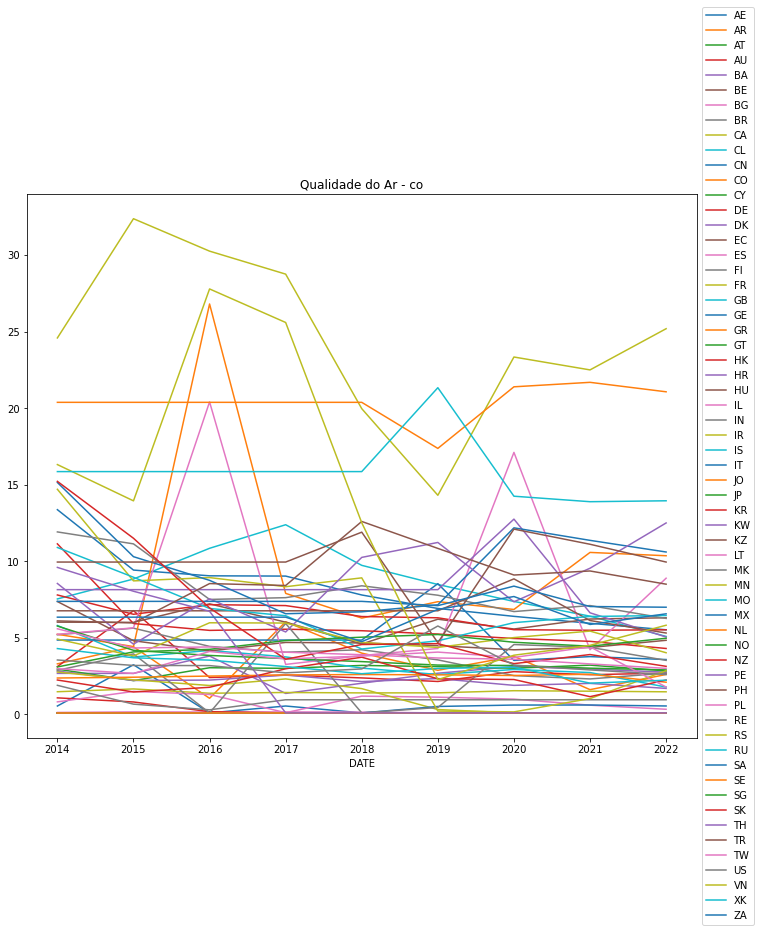

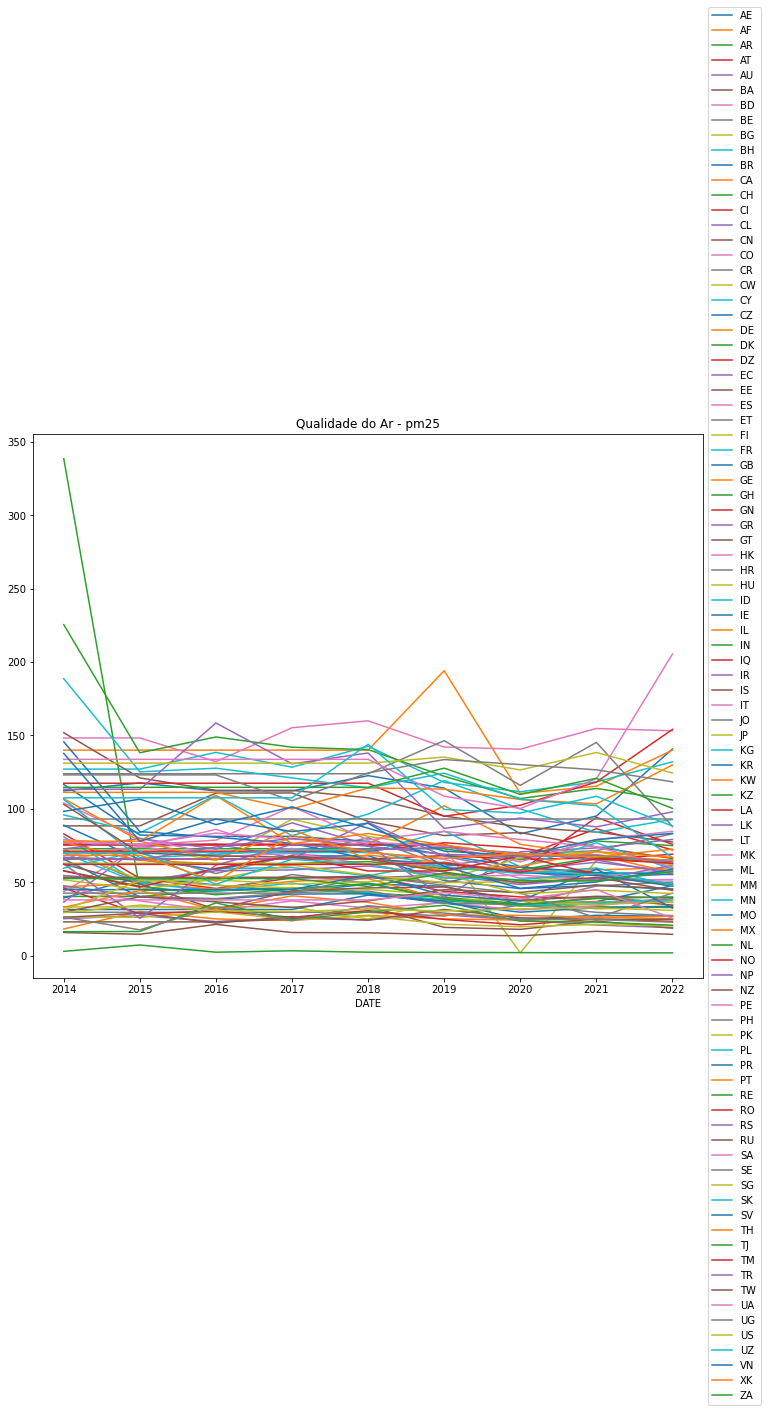

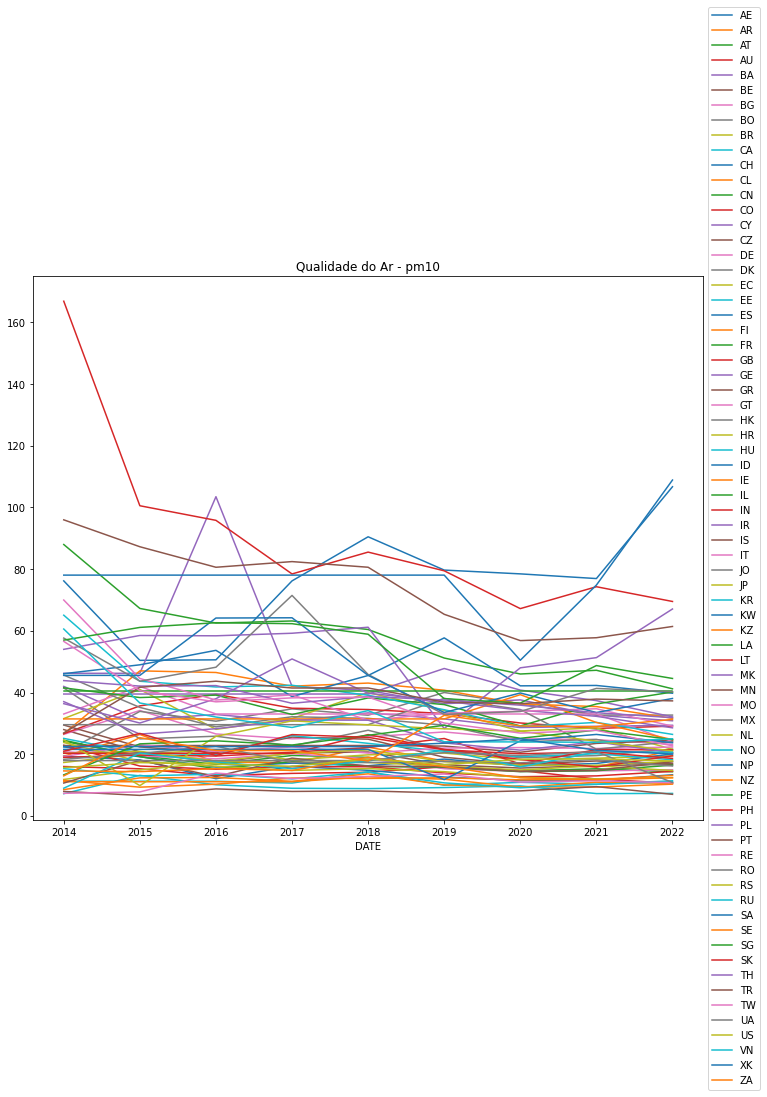

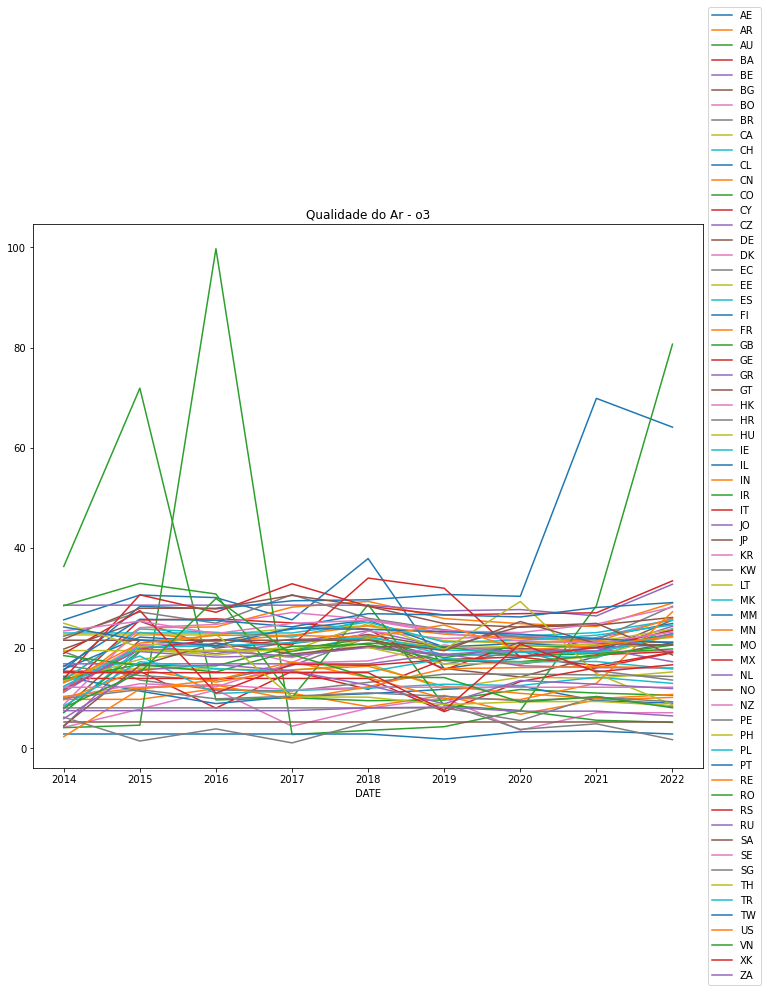

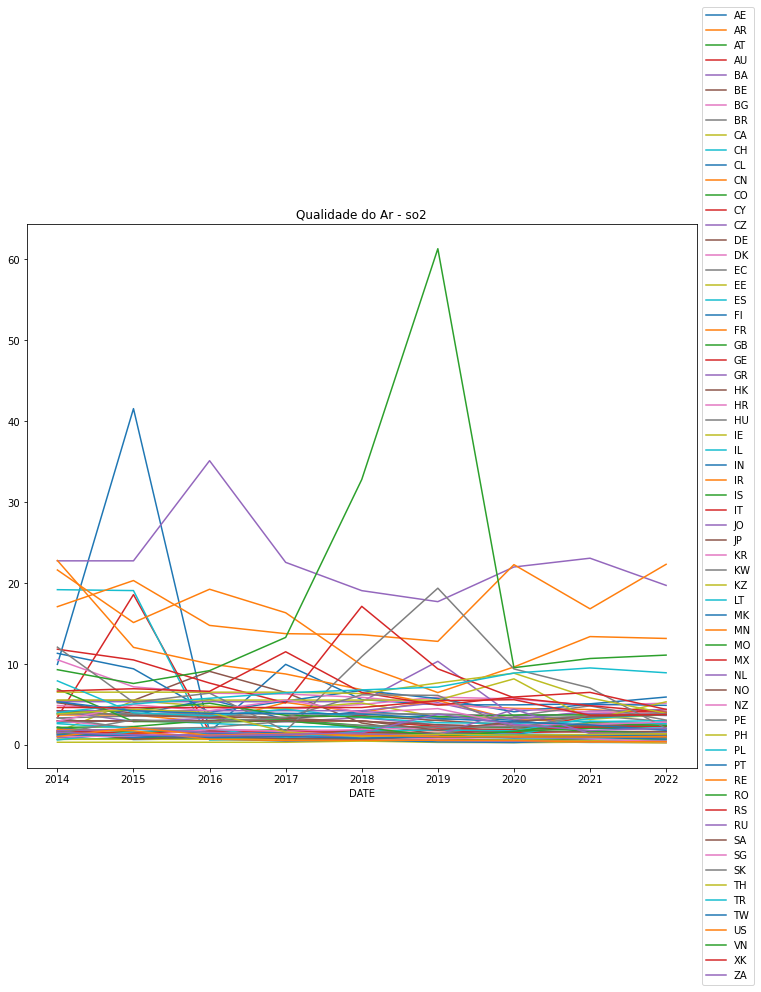

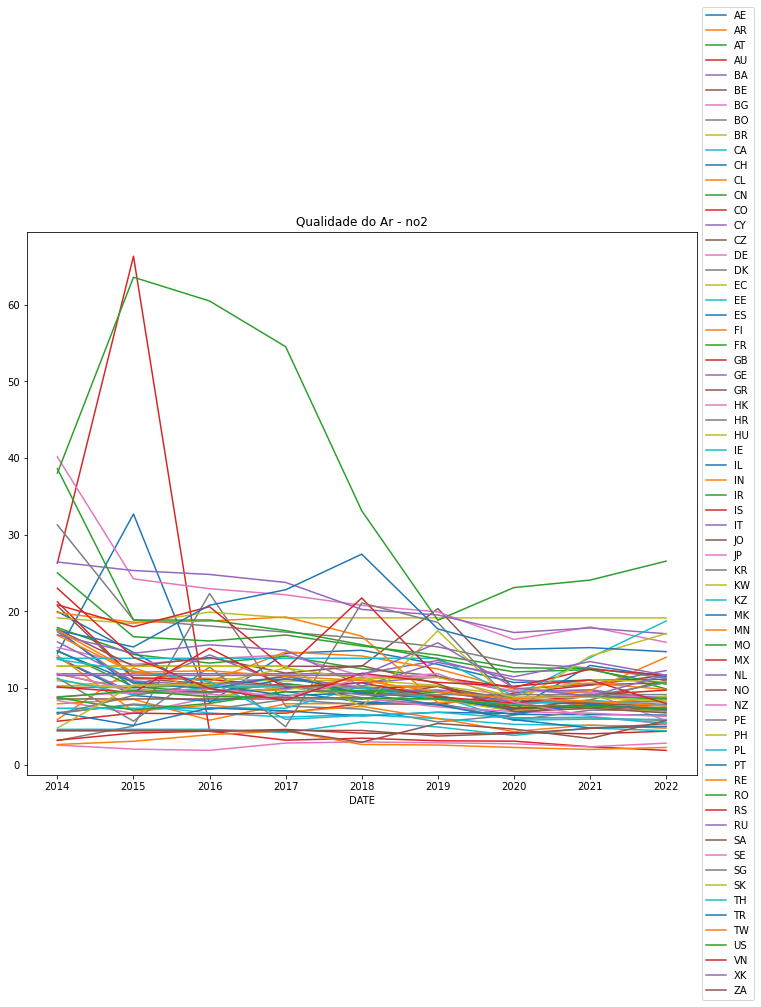

In [23]:
for idx, df_by_year_pivot in enumerate(dfs_pivot):
    df_by_year_pivot.plot.line(figsize=(12,10))

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(f"Qualidade do Ar - {species_list[idx]}")
    plt.show()

É possível enxergar uma tendência a aumentar em 2019 e uma queda drástica em 2020 possívelmente pela pandemia

## Agregando países

In [24]:
df_countries = pd.read_csv('../data/countries/country-continent.csv', sep=',')

In [25]:
df_countries = df_countries[['name','alpha-2','alpha-3','region']]
df_countries.columns = df_countries.columns.str.upper()
df_countries

,NAME,ALPHA-2,ALPHA-3,REGION
0,Afghanistan,AF,AFG,Asia
1,Åland Islands,AX,ALA,Europe
2,Albania,AL,ALB,Europe
3,Algeria,DZ,DZA,Africa
4,American Samoa,AS,ASM,Oceania
...,...,...,...,...
244,Wallis and Futuna,WF,WLF,Oceania
245,Western Sahara,EH,ESH,Africa
246,Yemen,YE,YEM,Asia
247,Zambia,ZM,ZMB,Africa


In [26]:
print(len(df_countries["ALPHA-2"].unique()))
for idx, df_by_year in enumerate(dfs):
    print("DF {}: {} países".format(species_list[idx], len(df_by_year["COUNTRY"].unique())))

249
DF co: 61 países
DF pm25: 93 países
DF pm10: 72 países
DF o3: 65 países
DF so2: 65 países
DF no2: 66 países


In [27]:
df_by_year_country_region = pd.merge(df_by_year_specie,df_countries,left_on='COUNTRY',right_on='ALPHA-2')
df_by_year_country_region = df_by_year_country_region[['DATE', 'NAME','ALPHA-2','ALPHA-3', 'REGION', 'SPECIE', 'MEAN_BY_COUNTRY']]
df_by_year_country_region.to_csv('../data/air-quality/results/iqar-countries.csv',index=False)
df_by_year_country_region

,DATE,NAME,ALPHA-2,ALPHA-3,REGION,SPECIE,MEAN_BY_COUNTRY
0,2014,Austria,AT,AUT,Europe,co,0.100000
1,2014,Austria,AT,AUT,Europe,no2,17.886667
2,2014,Austria,AT,AUT,Europe,pm10,24.200000
3,2014,Austria,AT,AUT,Europe,pm25,83.000000
4,2014,Austria,AT,AUT,Europe,so2,2.100000
...,...,...,...,...,...,...,...
3146,2020,Ghana,GH,GHA,Africa,pm25,65.369637
3147,2021,Ghana,GH,GHA,Africa,pm25,78.184066
3148,2022,Ghana,GH,GHA,Africa,pm25,75.008333
3149,2020,Guinea,GN,GIN,Africa,pm25,57.564014


In [28]:
df_by_year_region = df_by_year_country_region.groupby([df_by_year_country_region.DATE, df_by_year_country_region.REGION, df_by_year_country_region.SPECIE])['MEAN_BY_COUNTRY'].mean().rename('MEAN_BY_CONTINENT').reset_index()
df_by_year_region.to_csv('../data/air-quality/results/iqar-continents.csv',index=False)
df_by_year_region.head(10)

,DATE,REGION,SPECIE,MEAN_BY_CONTINENT
0,2014,Africa,no2,2.633333
1,2014,Africa,o3,10.333333
2,2014,Africa,pm10,10.166667
3,2014,Africa,pm25,16.333333
4,2014,Africa,so2,1.750000
5,2014,Americas,co,6.358942
6,2014,Americas,no2,8.751465
7,2014,Americas,o3,10.889843
8,2014,Americas,pm10,28.594598
9,2014,Americas,pm25,53.205987


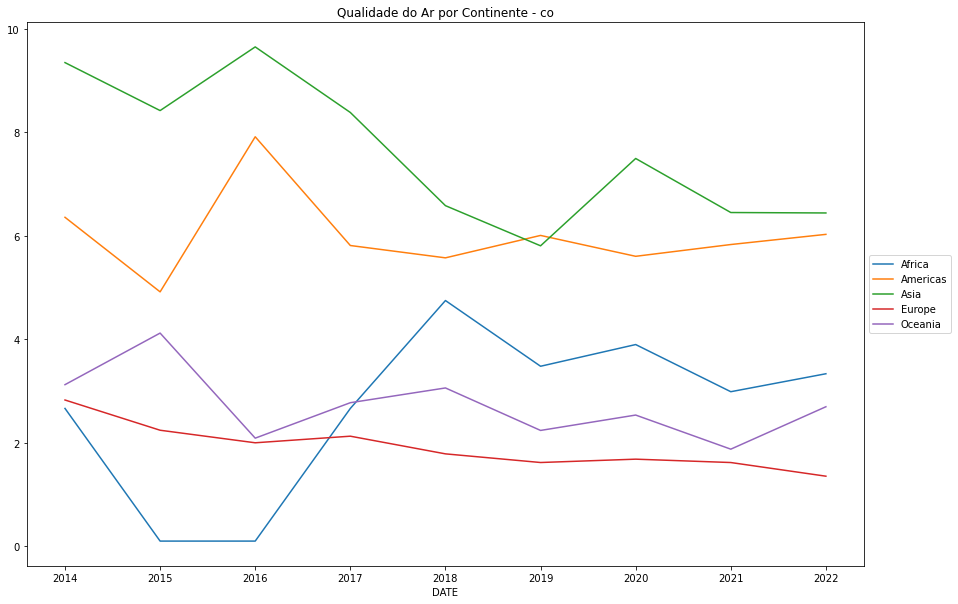

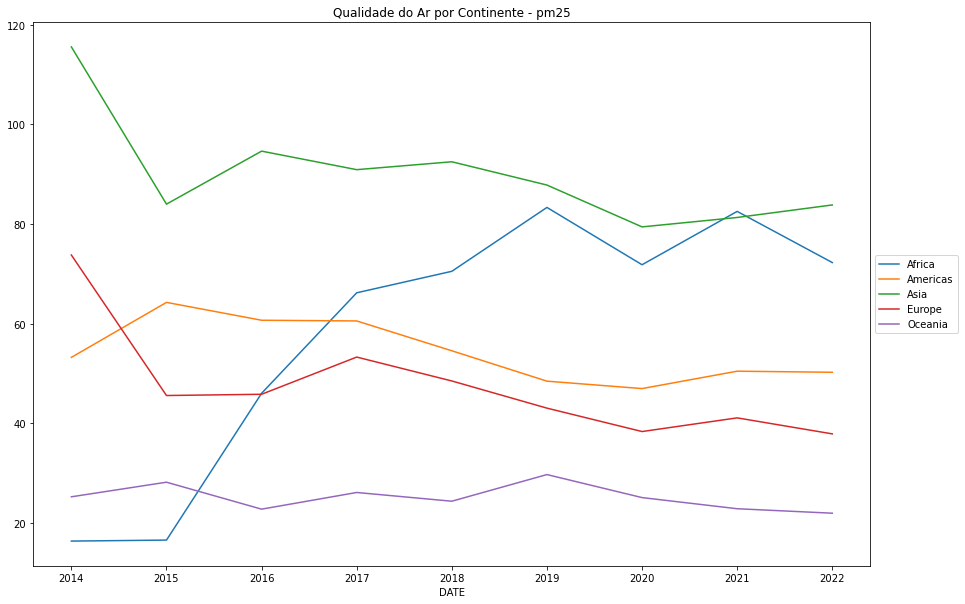

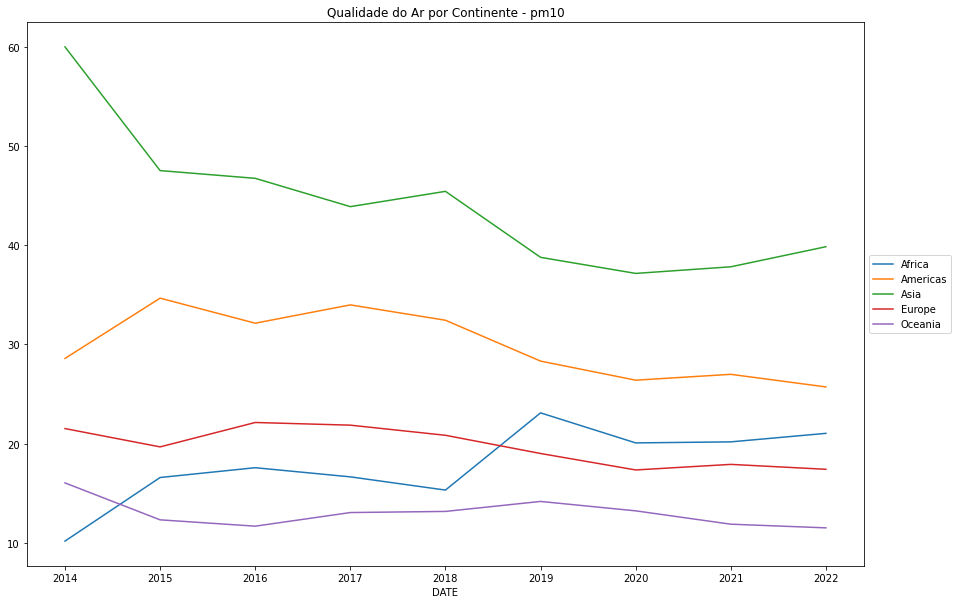

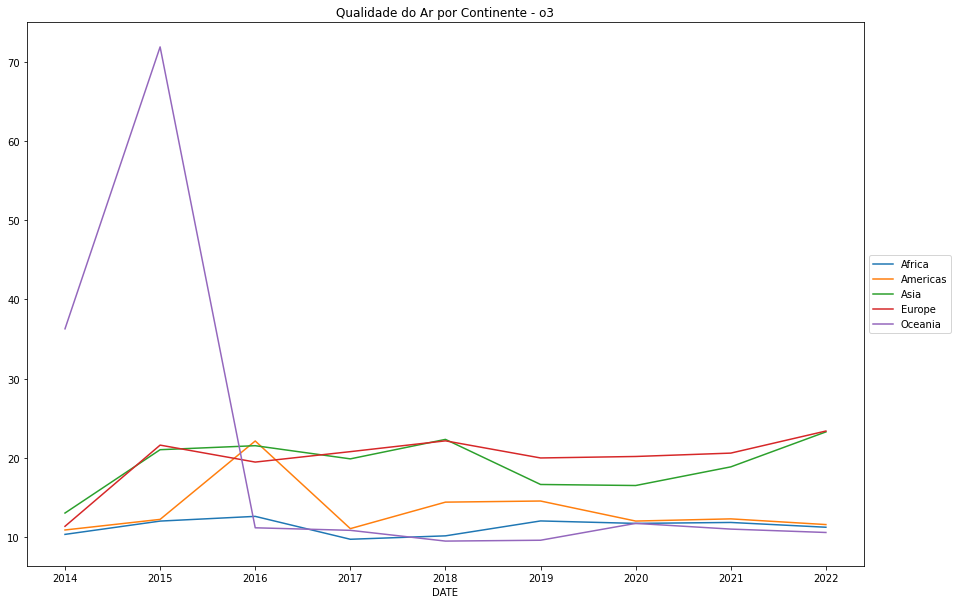

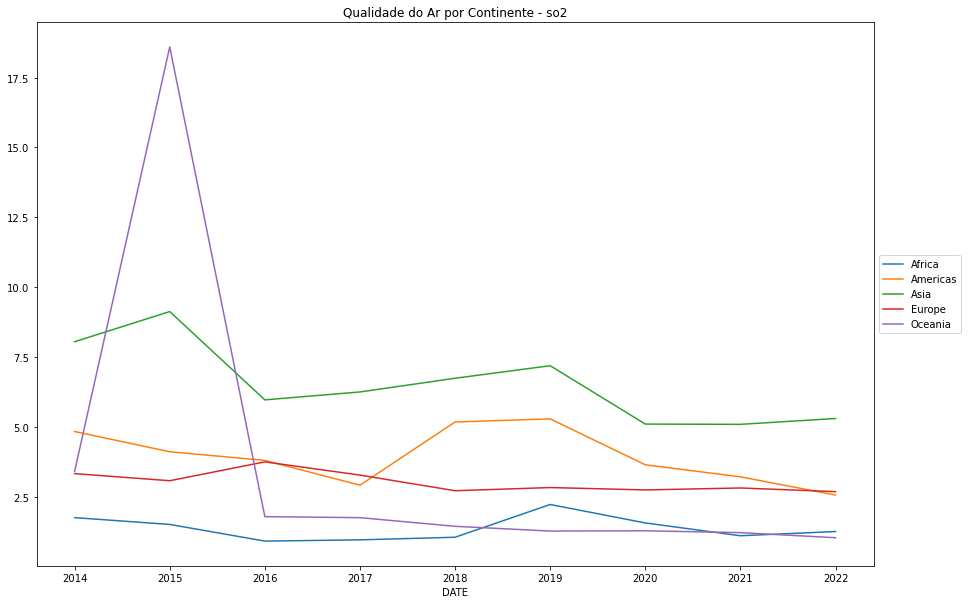

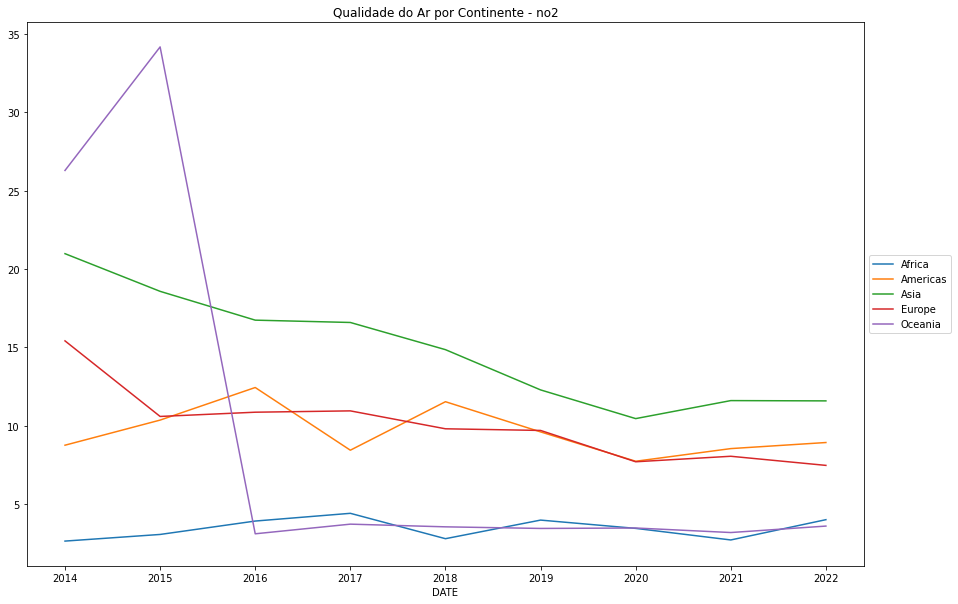

In [29]:
for specie in species_list:
    df_local = df_by_year_region.query(f'SPECIE == "{specie}"').pivot(index='DATE', columns='REGION', values='MEAN_BY_CONTINENT')
    df_local.fillna(df_local.mean()).plot.line(figsize=(15,10))

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(f"Qualidade do Ar por Continente - {specie}")
    plt.show()

Falta agregar população e ver pela taxa